# Integrating datasets with scBIOT in R

This tutorial requires Reticulate. Please check out our installation guide for instructions on installing Reticulate and scvi-tools.

In this tutorial, we go over how to use basic scBIOT functionality in R. If you have run the scBIOT and got UMAP embeddings in python and want to convert it into Seurat object. 



In [17]:
# # in python
# adata = sc.read(f"{dir}/inputs/lung_atlas.h5ad")

# # first save the UMAP and cluster labels
# umap_df = pd.DataFrame(
#     adata.obsm["X_umap"],
#     index=adata.obs_names,
#     columns=["UMAP_1", "UMAP_2"]
# )

# # Save to CSV
# umap_df.to_csv(f'{parent_dir}/outputs/IM05/HNSC_umap_coords.csv')

# cluster_df = pd.DataFrame(  
#     adata.obs['scBIOT_leiden']
# )

# # Save to CSV
# cluster_df.to_csv(f'{parent_dir}/outputs/IM05/HNSC_cluster_names.csv')

In [18]:
# # in R
# library(zellkonverter)
# # convert anndata to seurat object
# ad <- readH5AD(paste0(dir, "/inputs/lung_atlas.h5ad"))
# alldata <- as.Seurat(ad, counts = "X", data = NULL)

# # recreate assay5
# counts = alldata[["originalexp"]]@counts
# # rownames(counts) <- gsub("-.*", "", rownames(alldata))
# colnames(counts) <- colnames(alldata)

# # average duplicated genes
# gene_names <- rownames(counts)
# duplicated_genes <- duplicated(gene_names) | duplicated(gene_names, fromLast = TRUE)
# dense_mat <- as.matrix(counts)
# avg_mat <- rowsum(dense_mat, group = gene_names) / as.vector(table(gene_names))
# avg_mat <- round(avg_mat)
# counts <- as(avg_mat, "dgCMatrix")

# meta <- alldata@meta.data

# alldata <- CreateSeuratObject(counts = counts, assay = "RNA")
# alldata <- AddMetaData(alldata, metadata = meta)
# alldata@active.ident = alldata$orig.ident = alldata$sample_name

# # add UMAP
# # Read the exported UMAP coordinates
# umap_coords <- read.csv(paste0(dir, "/outputs/IM05/HNSC_umap_coords.csv"), row.names = 1)

# # Make sure rownames match
# if (!all(rownames(alldata@meta.data) %in% rownames(umap_coords))) {
#   stop("Mismatch between Seurat cells and UMAP coordinates")
# }

# # Subset UMAP to matching cells (optional but safer)
# umap_coords <- umap_coords[rownames(alldata@meta.data), ]

# # Assign to Seurat UMAP slot
# alldata[["umap"]] <- CreateDimReducObject(
#   embeddings = as.matrix(umap_coords),
#   key = "UMAP_",
#   assay = DefaultAssay(alldata)
# )

# # add cluster labels
# # Read the exported UMAP coordinates
# cluster_coords <- read.csv(paste0(dir, "/outputs/IM05/HNSC_cluster_names.csv"), row.names = 1)

# # Make sure rownames match
# if (!all(rownames(alldata@meta.data) %in% rownames(cluster_coords))) {
#   stop("Mismatch between Seurat cells and Cluster coordinates")
# }

# alldata <- AddMetaData(alldata, 
#                        metadata = cluster_coords, 
#                        col.name = "seurat_clusters")

# # add levels
# alldata$seurat_clusters <- factor(alldata$seurat_clusters, levels = sort(unique(alldata$seurat_clusters)))
# Idents(alldata) <- "seurat_clusters"

# alldata <- alldata %>% NormalizeData() %>% ScaleData()

# saveRDS(alldata, file = paste0(dir,"/outputs/IM06/all_cluster_annotation.rds"))

In [19]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scanpy as sc
import seaborn as sns
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
import torch
import os
import pandas as pd
import scbiot as scb
from scbiot.utils import set_seed

import harmonypy as hm
from umap import UMAP
# %pip install scib-metrics
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

set_seed(42)

from pathlib import Path
dir = Path.cwd()
print(dir)
parent_dir = dir.parent
print(parent_dir)


Random seed set as 42
/home/figo/software/python_libs/scbiot/examples/R
/home/figo/software/python_libs/scbiot/examples


In [20]:
adata_path = f"{dir}/ifnb.h5ad"

adata = sc.read(
    adata_path,
    # backup_url="https://figshare.com/ndownloader/files/24539942",
)
adata

AnnData object with n_obs × n_vars = 13997 × 14053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'pct_mt'
    var: 'name'

In [21]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3", batch_key='stim')
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.tl.pca(adata, n_comps=50, use_highly_variable=True)

In [22]:
adata, metrics = scb.ot.integrate(adata, 
                                  modality='rna', 
                                  obsm_key='X_pca', 
                                  batch_key='stim', 
                                  out_key='X_ot',
                                  ot_mode='unbalanced'
                                  )
print(metrics)

[baseline] KNN backend=FAISS-GPU mix=0.1163 strain=0.00000
[iter 01] mix=0.185 overlap0=0.803 strain=0.00491 floor~0.600 J=0.135 best_it=1
[iter 02] mix=0.272 overlap0=0.659 strain=0.01353 floor~0.607 J=0.209 best_it=2
[iter 03] mix=0.356 overlap0=0.542 strain=0.02316 floor~0.614 J=0.264 best_it=3
[iter 04] mix=0.445 overlap0=0.434 strain=0.03904 floor~0.621 J=0.275 best_it=4
[iter 05] mix=0.522 overlap0=0.355 strain=0.04489 floor~0.629 J=0.284 best_it=5
[iter 06] mix=0.574 overlap0=0.316 strain=0.04837 floor~0.636 J=0.302 best_it=6
[iter 07] mix=0.562 overlap0=0.299 strain=0.04988 floor~0.643 J=0.271 best_it=6
[iter 08] mix=0.556 overlap0=0.301 strain=0.05017 floor~0.650 J=0.260 best_it=6
[iter 09] mix=0.583 overlap0=0.290 strain=0.04949 floor~0.657 J=0.261 best_it=6
[early stop] plateau reached.
[final] it*=6 mix=0.574 overlap0=0.316 strain=0.04837 tw=0.936
{'mix': 0.5743189337458219, 'overlap0': 0.31611332297325134, 'strain': 0.04836765676736832, 'tw': 0.936306093569634, 'it': 6}


In [23]:
# 1. Compute neighbors using Harmony-corrected PCA
sc.pp.neighbors(adata, use_rep='X_ot')

# 2. Run UMAP 
sc.tl.umap(adata)

# 3. Leiden clustering
sc.tl.leiden(adata, resolution=0.8, key_added='leiden_X_ot')
adata

AnnData object with n_obs × n_vars = 13997 × 14053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'pct_mt', 'leiden_X_ot'
    var: 'name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden_X_ot'
    obsm: 'X_pca', 'X_ot', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

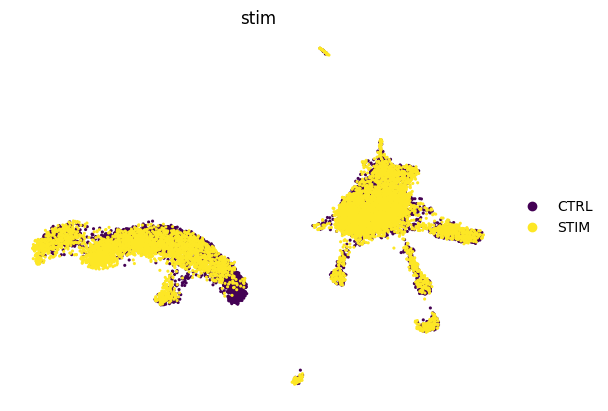

In [24]:
sc.pl.umap(
    adata,
    color=["stim"],  # replace with metadata keys
    palette="viridis",               # color map
    size=20,                         # point size
    frameon=False,                   # clean background
    ncols=2,                         # layout if plotting multiple
)
